# Kfold Validation

To actually guarantee the performance of the models we have trained, some validation is required. To this end we employ Kfold validation which is a method to change around the train and test sets to see if the performance is not caused by a fortunate split.  

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2 
import os
import pandas as pd
from scipy import ndimage
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

In [2]:
def calculate_centroid_and_area(image):
    
    img_hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    mask = cv2.inRange(img_hsv,(31, 69, 20), (82, 255, 255))
    
    area = np.sum(mask)/255
    centroid = ndimage.center_of_mass(mask)
    
    return [area,centroid]

In [3]:
# Assumes there are an equal number of top and front images
number_of_files = len([name for name in os.listdir('../Images') if name[0]!="."])
number_of_plants = int(number_of_files / 2)

results = pd.DataFrame(columns=['Plant_number', 'Area_front', 'Centroid_front', 'Area_top', 'Centroid_top'])

for x in range(number_of_plants):
    row = []
    
    row.append("Plant" + str(x+1))
    
    image_front = cv2.imread(f'../Images/Plant{x+1}_front_Color.png')
    image_top = cv2.imread(f'../Images/Plant{x+1}_top_Color.png')
    
    front_result = calculate_centroid_and_area(image_front)
    top_result = calculate_centroid_and_area(image_top)
    
    row = row + front_result + top_result
    
    results.loc[len(results)] = row
    
print(results)
    

   Plant_number  Area_front                           Centroid_front  \
0        Plant1     72055.0   (321.6569009784193, 667.9332315592256)   
1        Plant2     68354.0   (335.5661702314422, 706.0572607309009)   
2        Plant3     40422.0  (401.83724209588837, 649.1364850823809)   
3        Plant4     62747.0  (331.01727572632956, 692.3932937032846)   
4        Plant5     56655.0   (351.8390433324508, 751.1261671520607)   
5        Plant6     36733.0   (376.9781667710233, 719.6792802112542)   
6        Plant7     58318.0  (398.34088960526765, 653.4697691964745)   
7        Plant8     69904.0  (419.84069581139846, 630.2788395513847)   
8        Plant9     62220.0  (437.33539054966246, 648.5444069431051)   
9       Plant10     41865.0    (406.4778693419324, 614.602651379434)   
10      Plant11     58057.0    (392.908744854195, 675.5261208812029)   
11      Plant12     96526.0    (350.6438472535897, 666.881534508837)   
12      Plant13     90898.0    (352.8019208343418, 696.223525270

In [4]:
PlantData = pd.read_csv("../PlantData.csv")

In [5]:
Data = results.join(PlantData.set_index('Plant_number'), on='Plant_number')

In [6]:
# Separate Target Variable and Predictor Variables
TargetVariable=['LAI']
Predictors=['Area_top','Area_front']
 
X=Data[Predictors].values
y=Data[TargetVariable].values
 
### Sandardization of data ###
from sklearn.preprocessing import StandardScaler
PredictorScaler=StandardScaler()
TargetVarScaler=StandardScaler()
 
# Storing the fit object for later reference
PredictorScalerFit=PredictorScaler.fit(X)
TargetVarScalerFit=TargetVarScaler.fit(y)
 
# Generating the standardized values of X and y
X=PredictorScalerFit.transform(X)
y=TargetVarScalerFit.transform(y)
 

    
 

We use a k of 5 , which means there are 5 sets of 10 samples. Each set is then used as test set once and the results are averaged. This leads to an average perfomance of MAE 8,9% for the NN. we did the same for Random Forest and AutoML which resulted in MAE's of 10.4% and 11.3% respectively. With this information we move forward with the NN model

In [9]:
# Split the data into training and testing set
i=0
k=5
cv = KFold(n_splits=k, random_state=1, shuffle=True)
cv.get_n_splits(X)
mae=np.zeros(k)
for train_index, test_index in cv.split(X):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    # create ANN model
    model = Sequential()

    # Defining the Input layer and FIRST hidden layer, both are same!
    model.add(Dense(units=5, input_dim=2, kernel_initializer='normal', activation='relu'))

    # Defining the Second layer of the model
    # after the first layer we don't have to specify input_dim as keras configure it automatically
    model.add(Dense(units=5, kernel_initializer='normal', activation='tanh'))

    #extra layer
    #model.add(Dense(units=5, kernel_initializer='normal', activation='tanh'))


    # The output neuron is a single fully connected node 
    # Since we will be predicting a single number
    model.add(Dense(1, kernel_initializer='normal'))

    # Compiling the model
    model.compile(loss='mean_squared_error', optimizer='adam')

    # Fitting the ANN to the Training set
    model.fit(X_train, y_train ,batch_size = 20, epochs = 500, verbose=1)
    
    close_predictions = model.predict(X_test) 
    print(close_predictions)
    close_predictions = TargetVarScalerFit.inverse_transform(close_predictions)
    close_predictions = close_predictions.flatten()
    y_test = TargetVarScalerFit.inverse_transform(y_test)
    y_test = y_test.flatten()
    mae[i] = sum(abs(close_predictions - y_test)) / y_test.shape[0]
    i+=1
print(mae)
mae_average = np.average(mae)
maepercent_average = mae_average/np.average(Data['LAI'])
print(maepercent_average)

TRAIN: [ 0  1  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25
 26 28 30 32 33 34 36 37 39 41 42 43 44 45 47 49] TEST: [ 2  3 27 29 31 35 38 40 46 48]
Epoch 1/500
2/2 [==============================] - 0s 916us/step - loss: 0.9900
Epoch 2/500
2/2 [==============================] - 0s 1ms/step - loss: 0.9896
Epoch 3/500
2/2 [==============================] - 0s 2ms/step - loss: 0.9895
Epoch 4/500
2/2 [==============================] - 0s 1ms/step - loss: 0.9893
Epoch 5/500
2/2 [==============================] - 0s 1ms/step - loss: 0.9891
Epoch 6/500
2/2 [==============================] - 0s 546us/step - loss: 0.9887
Epoch 7/500
2/2 [==============================] - 0s 1ms/step - loss: 0.9884
Epoch 8/500
2/2 [==============================] - 0s 2ms/step - loss: 0.9881
Epoch 9/500
2/2 [==============================] - 0s 1ms/step - loss: 0.9878
Epoch 10/500
2/2 [==============================] - 0s 798us/step - loss: 0.9873
Epoch 11/500
2/2 [===========================

2/2 [==============================] - 0s 1ms/step - loss: 0.2078
Epoch 203/500
2/2 [==============================] - 0s 1ms/step - loss: 0.2074
Epoch 204/500
2/2 [==============================] - 0s 502us/step - loss: 0.2072
Epoch 205/500
2/2 [==============================] - 0s 1ms/step - loss: 0.2069
Epoch 206/500
2/2 [==============================] - 0s 2ms/step - loss: 0.2068
Epoch 207/500
2/2 [==============================] - 0s 1ms/step - loss: 0.2064
Epoch 208/500
2/2 [==============================] - 0s 1ms/step - loss: 0.2062
Epoch 209/500
2/2 [==============================] - 0s 2ms/step - loss: 0.2060
Epoch 210/500
2/2 [==============================] - 0s 2ms/step - loss: 0.2057
Epoch 211/500
2/2 [==============================] - 0s 1ms/step - loss: 0.2054
Epoch 212/500
2/2 [==============================] - 0s 973us/step - loss: 0.2053
Epoch 213/500
2/2 [==============================] - 0s 1000us/step - loss: 0.2051
Epoch 214/500
2/2 [============================

Epoch 304/500
2/2 [==============================] - 0s 1ms/step - loss: 0.1979
Epoch 305/500
2/2 [==============================] - 0s 2ms/step - loss: 0.1980
Epoch 306/500
2/2 [==============================] - 0s 1ms/step - loss: 0.1979
Epoch 307/500
2/2 [==============================] - 0s 1ms/step - loss: 0.1979
Epoch 308/500
2/2 [==============================] - 0s 2ms/step - loss: 0.1980
Epoch 309/500
2/2 [==============================] - 0s 1ms/step - loss: 0.1980
Epoch 310/500
2/2 [==============================] - 0s 2ms/step - loss: 0.1980
Epoch 311/500
2/2 [==============================] - 0s 1ms/step - loss: 0.1978
Epoch 312/500
2/2 [==============================] - 0s 2ms/step - loss: 0.1978
Epoch 313/500
2/2 [==============================] - 0s 1ms/step - loss: 0.1978
Epoch 314/500
2/2 [==============================] - 0s 2ms/step - loss: 0.1977
Epoch 315/500
2/2 [==============================] - 0s 2ms/step - loss: 0.1977
Epoch 316/500
2/2 [=====================

2/2 [==============================] - 0s 1000us/step - loss: 0.1970
Epoch 407/500
2/2 [==============================] - 0s 575us/step - loss: 0.1971
Epoch 408/500
2/2 [==============================] - 0s 1ms/step - loss: 0.1969
Epoch 409/500
2/2 [==============================] - 0s 2ms/step - loss: 0.1969
Epoch 410/500
2/2 [==============================] - 0s 1ms/step - loss: 0.1968
Epoch 411/500
2/2 [==============================] - 0s 2ms/step - loss: 0.1970
Epoch 412/500
2/2 [==============================] - 0s 997us/step - loss: 0.1969
Epoch 413/500
2/2 [==============================] - 0s 497us/step - loss: 0.1968
Epoch 414/500
2/2 [==============================] - 0s 2ms/step - loss: 0.1970
Epoch 415/500
2/2 [==============================] - 0s 1ms/step - loss: 0.1968
Epoch 416/500
2/2 [==============================] - 0s 1ms/step - loss: 0.1969
Epoch 417/500
2/2 [==============================] - 0s 523us/step - loss: 0.1970
Epoch 418/500
2/2 [========================

[[-1.8695563 ]
 [-0.7965    ]
 [ 0.55346423]
 [-0.01873834]
 [ 0.6718195 ]
 [ 0.33698124]
 [ 0.825384  ]
 [ 0.5334063 ]
 [-0.53956723]
 [ 1.1081388 ]]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 14 15 16 17 18 20 23 24 25 27 28
 29 30 31 33 34 35 37 38 40 41 43 44 45 46 47 48] TEST: [13 19 21 22 26 32 36 39 42 49]
Epoch 1/500
2/2 [==============================] - 0s 9ms/step - loss: 1.0271
Epoch 2/500
2/2 [==============================] - 0s 2ms/step - loss: 1.0260
Epoch 3/500
2/2 [==============================] - 0s 1ms/step - loss: 1.0248
Epoch 4/500
2/2 [==============================] - 0s 1ms/step - loss: 1.0239
Epoch 5/500
2/2 [==============================] - 0s 1ms/step - loss: 1.0227
Epoch 6/500
2/2 [==============================] - 0s 1ms/step - loss: 1.0221
Epoch 7/500
2/2 [==============================] - 0s 1ms/step - loss: 1.0214
Epoch 8/500
2/2 [==============================] - 0s 1ms/step - loss: 1.0201
Epoch 9/500
2/2 [==============================] - 0s 1ms

2/2 [==============================] - 0s 1ms/step - loss: 0.1653
Epoch 203/500
2/2 [==============================] - 0s 1ms/step - loss: 0.1652
Epoch 204/500
2/2 [==============================] - 0s 1ms/step - loss: 0.1650
Epoch 205/500
2/2 [==============================] - 0s 1ms/step - loss: 0.1649
Epoch 206/500
2/2 [==============================] - 0s 2ms/step - loss: 0.1647
Epoch 207/500
2/2 [==============================] - 0s 733us/step - loss: 0.1645
Epoch 208/500
2/2 [==============================] - 0s 1ms/step - loss: 0.1644
Epoch 209/500
2/2 [==============================] - 0s 500us/step - loss: 0.1643
Epoch 210/500
2/2 [==============================] - 0s 1ms/step - loss: 0.1642
Epoch 211/500
2/2 [==============================] - 0s 1ms/step - loss: 0.1640
Epoch 212/500
2/2 [==============================] - 0s 1ms/step - loss: 0.1639
Epoch 213/500
2/2 [==============================] - 0s 1ms/step - loss: 0.1638
Epoch 214/500
2/2 [==============================]

2/2 [==============================] - 0s 1ms/step - loss: 0.1592
Epoch 407/500
2/2 [==============================] - 0s 1ms/step - loss: 0.1592
Epoch 408/500
2/2 [==============================] - 0s 2ms/step - loss: 0.1593
Epoch 409/500
2/2 [==============================] - 0s 2ms/step - loss: 0.1593
Epoch 410/500
2/2 [==============================] - 0s 1ms/step - loss: 0.1592
Epoch 411/500
2/2 [==============================] - 0s 1000us/step - loss: 0.1594
Epoch 412/500
2/2 [==============================] - 0s 2ms/step - loss: 0.1592
Epoch 413/500
2/2 [==============================] - 0s 1ms/step - loss: 0.1592
Epoch 414/500
2/2 [==============================] - 0s 1ms/step - loss: 0.1593
Epoch 415/500
2/2 [==============================] - 0s 2ms/step - loss: 0.1593
Epoch 416/500
2/2 [==============================] - 0s 2ms/step - loss: 0.1592
Epoch 417/500
2/2 [==============================] - 0s 2ms/step - loss: 0.1592
Epoch 418/500
2/2 [==============================] 

[[ 0.12155244]
 [ 0.4195873 ]
 [-0.44529372]
 [ 0.5898033 ]
 [ 0.5678264 ]
 [ 0.6423969 ]
 [ 0.7184162 ]
 [ 1.0318036 ]
 [ 0.0724344 ]
 [ 0.38314462]]
TRAIN: [ 0  1  2  3  5  6  7  8  9 11 12 13 15 16 18 19 20 21 22 25 26 27 28 29
 31 32 34 35 36 37 38 39 40 42 43 44 46 47 48 49] TEST: [ 4 10 14 17 23 24 30 33 41 45]
Epoch 1/500
2/2 [==============================] - 0s 0s/step - loss: 1.0782
Epoch 2/500
2/2 [==============================] - 0s 992us/step - loss: 1.0779
Epoch 3/500
2/2 [==============================] - 0s 2ms/step - loss: 1.0775
Epoch 4/500
2/2 [==============================] - 0s 2ms/step - loss: 1.0774
Epoch 5/500
2/2 [==============================] - 0s 2ms/step - loss: 1.0770
Epoch 6/500
2/2 [==============================] - 0s 1ms/step - loss: 1.0767
Epoch 7/500
2/2 [==============================] - 0s 2ms/step - loss: 1.0764
Epoch 8/500
2/2 [==============================] - 0s 2ms/step - loss: 1.0762
Epoch 9/500
2/2 [==============================] - 0s 35

2/2 [==============================] - 0s 1ms/step - loss: 0.3153
Epoch 101/500
2/2 [==============================] - 0s 1ms/step - loss: 0.3107
Epoch 102/500
2/2 [==============================] - 0s 2ms/step - loss: 0.3074
Epoch 103/500
2/2 [==============================] - 0s 1ms/step - loss: 0.3029
Epoch 104/500
2/2 [==============================] - 0s 2ms/step - loss: 0.2990
Epoch 105/500
2/2 [==============================] - 0s 1ms/step - loss: 0.2956
Epoch 106/500
2/2 [==============================] - 0s 2ms/step - loss: 0.2922
Epoch 107/500
2/2 [==============================] - 0s 1ms/step - loss: 0.2896
Epoch 108/500
2/2 [==============================] - 0s 1ms/step - loss: 0.2865
Epoch 109/500
2/2 [==============================] - 0s 1ms/step - loss: 0.2832
Epoch 110/500
2/2 [==============================] - 0s 3ms/step - loss: 0.2807
Epoch 111/500
2/2 [==============================] - 0s 953us/step - loss: 0.2777
Epoch 112/500
2/2 [==============================] -

2/2 [==============================] - 0s 1ms/step - loss: 0.1906
Epoch 203/500
2/2 [==============================] - 0s 1ms/step - loss: 0.1903
Epoch 204/500
2/2 [==============================] - 0s 2ms/step - loss: 0.1900
Epoch 205/500
2/2 [==============================] - 0s 998us/step - loss: 0.1896
Epoch 206/500
2/2 [==============================] - 0s 1ms/step - loss: 0.1894
Epoch 207/500
2/2 [==============================] - 0s 1000us/step - loss: 0.1890
Epoch 208/500
2/2 [==============================] - 0s 1ms/step - loss: 0.1888
Epoch 209/500
2/2 [==============================] - 0s 2ms/step - loss: 0.1885
Epoch 210/500
2/2 [==============================] - 0s 1ms/step - loss: 0.1883
Epoch 211/500
2/2 [==============================] - 0s 1ms/step - loss: 0.1878
Epoch 212/500
2/2 [==============================] - 0s 1ms/step - loss: 0.1877
Epoch 213/500
2/2 [==============================] - 0s 2ms/step - loss: 0.1873
Epoch 214/500
2/2 [==============================

2/2 [==============================] - 0s 2ms/step - loss: 0.1755
Epoch 406/500
2/2 [==============================] - 0s 2ms/step - loss: 0.1754
Epoch 407/500
2/2 [==============================] - 0s 2ms/step - loss: 0.1754
Epoch 408/500
2/2 [==============================] - 0s 1ms/step - loss: 0.1755
Epoch 409/500
2/2 [==============================] - 0s 2ms/step - loss: 0.1754
Epoch 410/500
2/2 [==============================] - 0s 1ms/step - loss: 0.1753
Epoch 411/500
2/2 [==============================] - 0s 1ms/step - loss: 0.1753
Epoch 412/500
2/2 [==============================] - 0s 1ms/step - loss: 0.1753
Epoch 413/500
2/2 [==============================] - 0s 2ms/step - loss: 0.1753
Epoch 414/500
2/2 [==============================] - 0s 999us/step - loss: 0.1753
Epoch 415/500
2/2 [==============================] - 0s 2ms/step - loss: 0.1753
Epoch 416/500
2/2 [==============================] - 0s 2ms/step - loss: 0.1753
Epoch 417/500
2/2 [==============================] -

[[-1.6053494 ]
 [-1.4917599 ]
 [-0.1098133 ]
 [ 1.0280708 ]
 [-0.60726297]
 [-0.10922269]
 [-0.8134011 ]
 [ 0.5199199 ]
 [-0.5532925 ]
 [ 0.5961458 ]]
TRAIN: [ 0  2  3  4  5  8  9 10 11 12 13 14 15 16 17 19 21 22 23 24 26 27 29 30
 31 32 33 35 36 37 38 39 40 41 42 43 45 46 48 49] TEST: [ 1  6  7 18 20 25 28 34 44 47]
Epoch 1/500
2/2 [==============================] - 0s 0s/step - loss: 0.9667
Epoch 2/500
2/2 [==============================] - 0s 1ms/step - loss: 0.9663
Epoch 3/500
2/2 [==============================] - 0s 2ms/step - loss: 0.9658
Epoch 4/500
2/2 [==============================] - 0s 992us/step - loss: 0.9655
Epoch 5/500
2/2 [==============================] - 0s 1ms/step - loss: 0.9650
Epoch 6/500
2/2 [==============================] - 0s 956us/step - loss: 0.9646
Epoch 7/500
2/2 [==============================] - 0s 2ms/step - loss: 0.9644
Epoch 8/500
2/2 [==============================] - 0s 1ms/step - loss: 0.9640
Epoch 9/500
2/2 [==============================] - 0s 

2/2 [==============================] - 0s 2ms/step - loss: 0.1654
Epoch 203/500
2/2 [==============================] - 0s 2ms/step - loss: 0.1653
Epoch 204/500
2/2 [==============================] - 0s 918us/step - loss: 0.1651
Epoch 205/500
2/2 [==============================] - 0s 2ms/step - loss: 0.1650
Epoch 206/500
2/2 [==============================] - 0s 1ms/step - loss: 0.1650
Epoch 207/500
2/2 [==============================] - 0s 2ms/step - loss: 0.1649
Epoch 208/500
2/2 [==============================] - 0s 2ms/step - loss: 0.1649
Epoch 209/500
2/2 [==============================] - 0s 2ms/step - loss: 0.1648
Epoch 210/500
2/2 [==============================] - 0s 2ms/step - loss: 0.1646
Epoch 211/500
2/2 [==============================] - 0s 2ms/step - loss: 0.1645
Epoch 212/500
2/2 [==============================] - 0s 1ms/step - loss: 0.1646
Epoch 213/500
2/2 [==============================] - 0s 3ms/step - loss: 0.1644
Epoch 214/500
2/2 [==============================] -

2/2 [==============================] - 0s 2ms/step - loss: 0.1591
Epoch 407/500
2/2 [==============================] - 0s 2ms/step - loss: 0.1592
Epoch 408/500
2/2 [==============================] - 0s 2ms/step - loss: 0.1591
Epoch 409/500
2/2 [==============================] - 0s 2ms/step - loss: 0.1591
Epoch 410/500
2/2 [==============================] - 0s 1ms/step - loss: 0.1591
Epoch 411/500
2/2 [==============================] - 0s 1ms/step - loss: 0.1591
Epoch 412/500
2/2 [==============================] - 0s 1ms/step - loss: 0.1590
Epoch 413/500
2/2 [==============================] - 0s 1ms/step - loss: 0.1590
Epoch 414/500
2/2 [==============================] - 0s 1ms/step - loss: 0.1590
Epoch 415/500
2/2 [==============================] - 0s 1ms/step - loss: 0.1590
Epoch 416/500
2/2 [==============================] - 0s 1ms/step - loss: 0.1590
Epoch 417/500
2/2 [==============================] - 0s 1ms/step - loss: 0.1590
Epoch 418/500
2/2 [==============================] - 0

[[ 0.09652638]
 [-1.6928587 ]
 [-1.3242713 ]
 [-0.6099879 ]
 [ 0.678248  ]
 [ 0.7306169 ]
 [ 0.92951727]
 [ 0.6027761 ]
 [ 0.84863585]
 [ 0.8577768 ]]
TRAIN: [ 1  2  3  4  6  7 10 13 14 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31
 32 33 34 35 36 38 39 40 41 42 44 45 46 47 48 49] TEST: [ 0  5  8  9 11 12 15 16 37 43]
Epoch 1/500
2/2 [==============================] - 0s 0s/step - loss: 0.9398
Epoch 2/500
2/2 [==============================] - 0s 1ms/step - loss: 0.9392
Epoch 3/500
2/2 [==============================] - 0s 2ms/step - loss: 0.9386
Epoch 4/500
2/2 [==============================] - 0s 1ms/step - loss: 0.9382
Epoch 5/500
2/2 [==============================] - 0s 1ms/step - loss: 0.9379
Epoch 6/500
2/2 [==============================] - 0s 1ms/step - loss: 0.9374
Epoch 7/500
2/2 [==============================] - 0s 2ms/step - loss: 0.9369
Epoch 8/500
2/2 [==============================] - 0s 1ms/step - loss: 0.9365
Epoch 9/500
2/2 [==============================] - 0s 807u

2/2 [==============================] - 0s 869us/step - loss: 0.1540
Epoch 203/500
2/2 [==============================] - 0s 1ms/step - loss: 0.1537
Epoch 204/500
2/2 [==============================] - 0s 1ms/step - loss: 0.1535
Epoch 205/500
2/2 [==============================] - 0s 1ms/step - loss: 0.1532
Epoch 206/500
2/2 [==============================] - 0s 1ms/step - loss: 0.1529
Epoch 207/500
2/2 [==============================] - 0s 2ms/step - loss: 0.1526
Epoch 208/500
2/2 [==============================] - 0s 1ms/step - loss: 0.1523
Epoch 209/500
2/2 [==============================] - 0s 2ms/step - loss: 0.1521
Epoch 210/500
2/2 [==============================] - 0s 969us/step - loss: 0.1517
Epoch 211/500
2/2 [==============================] - 0s 2ms/step - loss: 0.1515
Epoch 212/500
2/2 [==============================] - 0s 1ms/step - loss: 0.1513
Epoch 213/500
2/2 [==============================] - 0s 2ms/step - loss: 0.1509
Epoch 214/500
2/2 [==============================]

2/2 [==============================] - 0s 546us/step - loss: 0.1398
Epoch 305/500
2/2 [==============================] - 0s 1ms/step - loss: 0.1397
Epoch 306/500
2/2 [==============================] - 0s 1ms/step - loss: 0.1396
Epoch 307/500
2/2 [==============================] - 0s 2ms/step - loss: 0.1397
Epoch 308/500
2/2 [==============================] - 0s 2ms/step - loss: 0.1395
Epoch 309/500
2/2 [==============================] - 0s 1ms/step - loss: 0.1394
Epoch 310/500
2/2 [==============================] - 0s 969us/step - loss: 0.1394
Epoch 311/500
2/2 [==============================] - 0s 2ms/step - loss: 0.1393
Epoch 312/500
2/2 [==============================] - 0s 1ms/step - loss: 0.1393
Epoch 313/500
2/2 [==============================] - 0s 1ms/step - loss: 0.1391
Epoch 314/500
2/2 [==============================] - 0s 1ms/step - loss: 0.1390
Epoch 315/500
2/2 [==============================] - 0s 1ms/step - loss: 0.1390
Epoch 316/500
2/2 [==============================]

2/2 [==============================] - 0s 1ms/step - loss: 0.1340
Epoch 407/500
2/2 [==============================] - 0s 2ms/step - loss: 0.1338
Epoch 408/500
2/2 [==============================] - 0s 958us/step - loss: 0.1338
Epoch 409/500
2/2 [==============================] - 0s 1ms/step - loss: 0.1336
Epoch 410/500
2/2 [==============================] - 0s 938us/step - loss: 0.1337
Epoch 411/500
2/2 [==============================] - 0s 2ms/step - loss: 0.1335
Epoch 412/500
2/2 [==============================] - 0s 1ms/step - loss: 0.1336
Epoch 413/500
2/2 [==============================] - 0s 1ms/step - loss: 0.1335
Epoch 414/500
2/2 [==============================] - 0s 2ms/step - loss: 0.1335
Epoch 415/500
2/2 [==============================] - 0s 1ms/step - loss: 0.1334
Epoch 416/500
2/2 [==============================] - 0s 1ms/step - loss: 0.1334
Epoch 417/500
2/2 [==============================] - 0s 1ms/step - loss: 0.1334
Epoch 418/500
2/2 [==============================]

[[-0.22185089]
 [-2.2013059 ]
 [-1.7504302 ]
 [-2.0987432 ]
 [ 0.39280167]
 [ 1.2491993 ]
 [ 0.15741876]
 [ 0.46000972]
 [ 0.9815506 ]
 [-0.71924603]]
[ 62.5580332  104.83607935  91.96947803 100.20302686 124.34739136]
0.08788550203417764


57.464911376953104
   Actuals  Predictions  Plant Numbers
2   964.64   933.275818              1
0  1199.86  1136.443115              2
3  1216.18  1252.996582              3
9  1220.36  1210.642822              4
8  1321.61  1288.499634              5
7  1335.69  1256.988770              6
5  1343.02  1368.212769              7
6  1358.58  1261.859009              8
4  1363.92  1354.063232              9
1  1606.91  1417.157837             10


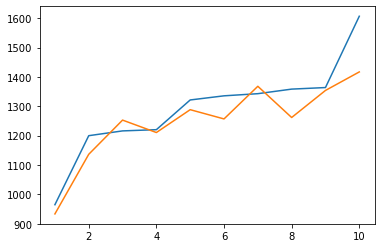

In [70]:
close_predictions = model.predict(X_test)   
close_predictions = TargetVarScalerFit.inverse_transform(close_predictions)
close_predictions = close_predictions.flatten()
y_test = TargetVarScalerFit.inverse_transform(y_test)
y_test = y_test.flatten()
mae = sum(abs(close_predictions - y_test)) / y_test.shape[0]

print(mae)
NN_results = pd.DataFrame(columns = ['Actuals'])
NN_results['Predictions'] = close_predictions
NN_results['Actuals'] = y_test


NN_results.sort_values(by=['Actuals'],inplace = True)
NN_results['Plant Numbers'] = np.arange(1,11).tolist()
print(NN_results)

plt.plot(NN_results['Plant Numbers'],NN_results['Actuals'],NN_results['Plant Numbers'],NN_results['Predictions'])

In [71]:
mae/np.average(NN_results['Actuals'])

0.044440440419985135